In [0]:
import os
import numpy as np
import pandas as pd

from torch.utils import data
import torch, torchvision
from torch import nn, optim

from sklearn import metrics
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Functions and Classes

In [0]:
# implement the MNISTNet network architecture
class CNN(nn.Module):
    
    # define the class constructor
    def __init__(self):
        
        self.name = "CNN"

        # call super class constructor
        super(CNN, self).__init__()
        
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            # nn.BatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2)
        )

        self.convlayer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2)
        )

        self.convlayer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU()
            # nn.MaxPool2d(2,stride=2)
        )

        self.convlayer4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            nn.Flatten()
        )

        # specify fully-connected (fc) layer 1 - in 28*28, out 300
        self.linear1 = nn.Linear(3*3*128, 256, bias=True) # the linearity W*x+b
        self.relu1 = nn.ReLU() # the non-linearity 
        self.dropout1 = nn.Dropout2d(p=0.2)

        # specify fully-connected (fc) layer 1 - in 28*28, out 300
        self.linear2 = nn.Linear(256, 256, bias=True) # the linearity W*x+b
        self.relu2 = nn.ReLU() # the non-linearity 
        self.dropout2 = nn.Dropout2d(p=0.2)

        # specify fully-connected (fc) layer 1 - in 28*28, out 300
        self.linear3 = nn.Linear(256, 128, bias=True) # the linearity W*x+b
        self.relu3 = nn.ReLU() # the non-linearity 
        self.dropout3 = nn.Dropout2d(p=0.2)
        
        # specify fc layer 2 - in 300, out 150
        self.linear4 = nn.Linear(128, 32, bias=True) # the linearity W*x+b
        self.relu4 = nn.ReLU() # the non-linearity

        # specify fc layer 2 - in 300, out 150
        self.linear5 = nn.Linear(32, 10, bias=True) # the linearity W*x+b
        # add a softmax to the last layer
        self.logsoftmax = nn.LogSoftmax(dim=1) # the softmax
        
    # define network forward pass
    def forward(self, images):
        
        # reshape image pixels
        # x = images.view(-1, 28*28)
        x = images.view(-1, 1, 28, 28)

        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = self.convlayer3(x)
        x = self.convlayer4(x)
        
        # define fc layer 1 forward pass
        x = self.dropout1(self.relu1(self.linear1(x)))
        # define fc layer 2 forward pass
        x = self.dropout2(self.relu2(self.linear2(x)))
        # define fc layer 2 forward pass
        x = self.dropout3(self.relu3(self.linear3(x)))
        x = self.relu4(self.linear4(x))
        # define layer 4 forward pass
        x = self.logsoftmax(self.linear5(x))
  
        # return forward pass result
        return x

    def get_name(self):
      return self.name

In [0]:
# Download data and convert it into numpy arrays
def init_data(mini_batch_size):

  if not os.path.exists('./data'): os.makedirs('./data')  # create data directory

  train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
  eval_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True)

  train_images = train_dataset.data.numpy().reshape(-1,28*28)
  train_labels = train_dataset.targets.data.numpy()

  eval_images = eval_dataset.data.numpy().reshape(-1,28*28)
  eval_labels = eval_dataset.targets.data.numpy()

  tensor_train_dataset = data.TensorDataset(torch.Tensor(train_images), torch.Tensor(train_labels))
  train_dataloader = data.DataLoader(tensor_train_dataset, batch_size=mini_batch_size, shuffle=True)

  tensor_eval_dataset = data.TensorDataset(torch.Tensor(eval_images), torch.Tensor(eval_labels))
  eval_dataloader = data.DataLoader(tensor_eval_dataset, batch_size=mini_batch_size, shuffle=True)

  return train_dataloader, eval_dataloader, tensor_train_dataset, tensor_eval_dataset

In [0]:
def init_gpu_np_seed(seed_value, use_gpu):

  np.random.seed(seed_value)

  torch.manual_seed(seed_value)
  torch.cuda.manual_seed(seed_value)

In [0]:
def init_model(model_type, use_gpu):

  if model_type == "CNN":
    
    model = CNN()

  elif model_type == "ANN":

    model = ANN()

  # print the initialized architectures
  print('Loaded CNN architecture:\n\n{}\n'.format(model))

  # init the number of model parameters
  num_params = 0

  # iterate over the distinct parameters
  for param in model.parameters():

      # collect number of parameters
      num_params += param.numel()
      
  # print the number of model paramters
  print('Number of parameters in CNN model: {}.'.format(num_params))

  if use_gpu:

    model = model.cuda()

  return model

In [0]:
def init_loss_fn(fn_type, use_gpu):
  
  loss_fn = ""
  
  if fn_type == "CE":
    
    loss_fn = nn.CrossEntropyLoss()

  elif fn_type == "NLL":
    
    loss_fn = nn.NLLLoss()

  if use_gpu:
    
    loss_fn = loss_fn.cuda()

  return loss_fn

In [0]:
def init_optim(model, optim_type, learning_rate, decay_rate=0):

  optimizer = ""

  if optim_type == "Adam":

    optimizer = optim.Adam(params=model.parameters() , amsgrad=True, lr=learning_rate)

  elif optim_type == "SGD_mom":

    optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, momentum=0.9)
  
  elif optim_type == "SGD":

    optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, weight_decay = decay_rate)

  return optimizer


In [0]:
def train_model(model, train_dataloader, loss_fn, optimizer, use_gpu):

  if not os.path.exists('./models'): os.makedirs('./models')  # create trained models directory

  # init collection of training epoch losses
  train_epoch_losses = []

  best_epoch = [-1,1]

  # set the model in training mode
  model.train()

  # train the MNISTNet model
  for epoch in range(num_epochs):
      
      # init collection of mini-batch losses
      train_mini_batch_losses = []
      
      # iterate over all-mini batches
      for i, (images, labels) in enumerate(train_dataloader):
          
          # case: gpu computing enabled
          if use_gpu == True:

            # convert images and labels to cuda tensor
            images = images.cuda()
            labels = labels.cuda()
          
          # run forward pass through the network
          output = model(images)
          
          # reset graph gradients
          model.zero_grad()

          # determine classification loss
          loss = loss_fn(output, labels.long())
          
          # run backward pass
          loss.backward()
          
          # update network paramaters
          optimizer.step()
          
          # collect mini-batch reconstruction loss
          train_mini_batch_losses.append(loss.data.item())
      
      # determine mean min-batch loss of epoch
      train_epoch_loss = np.mean(train_mini_batch_losses)

      if train_epoch_loss < best_epoch[1]:
        best_epoch = [epoch,train_epoch_loss]

      print('epoch: {} train-loss: {}'.format( str(epoch), str(train_epoch_loss)))
      
      # # save model to local directory
      model_name = '{}_epoch_{}.pth'.format(model.get_name(),str(epoch))
      torch.save(model.state_dict(), os.path.join("./models", model_name))
      
      # determine mean min-batch loss of epoch
      train_epoch_losses.append(train_epoch_loss)

  return best_epoch

In [0]:
def test_model(model_type, eval_dataloader, eval_dataset, loss_fn, best_epoch):

  model = init_model(model_type, False)

  best_epoch_file = '{}_epoch_{}.pth'.format(str(model.get_name()),str(best_epoch[0]))

  model.load_state_dict(torch.load(os.path.join("./models", best_epoch_file), map_location='cpu'))

  print("Epoch {} for {} model has been loaded".format(best_epoch[0],model.get_name()))

  # init collection of mini-batch losses
  eval_mini_batch_losses = []

  # iterate over all-mini batches
  for i, (images, labels) in enumerate(eval_dataloader):

      # run forward pass through the network
      output = model(images)

      # determine classification loss
      loss = loss_fn(output, labels.long())

      # collect mini-batch reconstruction loss
      eval_mini_batch_losses.append(loss.data.item())

  # determine mean min-batch loss of epoch
  eval_loss = np.mean(eval_mini_batch_losses)

  # print epoch loss
  print('Eval-loss for {} model: {}'.format(model.get_name(),str(eval_loss)))

  accuracy_summary(model, eval_dataset.tensors)


In [0]:
def accuracy_summary(model, eval_dataset):

  predictions = torch.argmax(model(eval_dataset[0].float()), dim=1)
  print("Accuracy achieved :",metrics.accuracy_score(eval_dataset[1], predictions.detach()) * 100, "%")

  # determine classification matrix of the predicted and target classes
  mat = confusion_matrix(eval_dataset[1], predictions.detach())

  # plot corresponding confusion matrix
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=range(0,10), yticklabels=range(0,10))
  plt.title('MNIST classification matrix')
  plt.xlabel('[true label]')
  plt.ylabel('[predicted label]');

# ANN Model

## ANN Parameters

In [0]:
# ANN Parameters
num_epochs = 1
mini_batch_size = 32
learning_rate = 0.001
decay_rate = 0.01
loss_fn_type = "CE"
model_type = "CNN"
optim_type = "Adam"
use_gpu = True
seed_value = 1234

## Running ANN

In [0]:
train_dataloader, eval_dataloader, train_dataset, eval_dataset = init_data(mini_batch_size)

init_gpu_np_seed( seed_value , use_gpu )

model = init_model( model_type ,use_gpu )
optimizer = init_optim( model , optim_type , learning_rate , decay_rate)
loss_fn = init_loss_fn( loss_fn_type , use_gpu )

In [0]:
best_epoch = train_model(model, train_dataloader, loss_fn, optimizer, use_gpu)

In [0]:
test_model(model_type, eval_dataloader, eval_dataset, loss_fn)

# CNN Model

## CNN Parameters

In [0]:
# CNN Parameters
num_epochs = 200
mini_batch_size = 32
learning_rate = 0.0001
loss_fn_type = "CE"
model_type = "CNN"
optim_type = "Adam"
use_gpu = True
seed_value = 1234

## Running CNN

In [0]:
train_dataloader, eval_dataloader, train_dataset, eval_dataset = init_data(mini_batch_size)

init_gpu_np_seed( seed_value , use_gpu )

model = init_model( model_type ,use_gpu )
optimizer = init_optim( model , optim_type , learning_rate)
loss_fn = init_loss_fn( loss_fn_type , use_gpu )

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Loaded CNN architecture:

CNN(
  (convlayer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convlayer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convlayer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (convlayer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten()
  )
  (linear1): Linear(in_features=1152, out_features=256, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout2d(p=0.2, inplace=False)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (relu

In [0]:
best_epoch = train_model(model, train_dataloader, loss_fn, optimizer, use_gpu)

epoch: 0 train-loss: 0.6500908366004626


Loaded CNN architecture:

CNN(
  (convlayer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convlayer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convlayer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (convlayer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten()
  )
  (linear1): Linear(in_features=1152, out_features=256, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout2d(p=0.2, inplace=False)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (relu

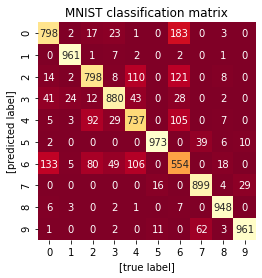

In [0]:
test_model(model_type, eval_dataloader, eval_dataset, loss_fn)